# Week5 homework-Monet Painting


**Problem Description**

Computer vision has made tremendous progress in recent years, and GANs are now able to model objects in a very convincing way. We identify an artist's work by their unique style, such as the choice of color or brushstrokes.

GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates images and the discriminator is trained using the discriminator. The two models will play against each other, with the generator trying to fool the discriminator, which is trying to accurately classify the real image versus the generated image.

I will generate Monet style images and build a GAN model to generate 7000 to 10000 Monet style images.



**Github URL**

https://github.com/rayangela528/DeepLearning-Monet



**Dataset Description**

DataSource: [I’m Something of a Painter Myself on Kaggle](https://www.kaggle.com/competitions/gan-getting-started/data) 

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

Files
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format


**Analysis and Modeling Process**

1. For a quick validation, I randomly sampled 100 images from the dataset for training.
2. I printed information about the dataset and a few images from the Monet and Photo folders.
3. Check the dimensions of the image and the dominant colors in the image.
4. Check if there are any corrupted image files.
5. Resize all images to the same resolution (e.g. 256x256).
6. Normalize image pixel values to the range [-1, 1] or [0, 1].



**Model Training**

1. Select model: CycleGAN is used as it is well suited for image-to-image style transfer tasks. Instead of requiring pairwise data (i.e., a photo and its corresponding Monet painting), CycleGAN learns a mapping between two styles via a Cycle Consistency Loss.
   
2. Model architecture:

   * Generator: Use U-Net or ResNet architecture, input photo, output Monet style image.

   * Discriminator: The PatchGAN architecture is used to determine whether the image is real or generated.

3. Loss function:

   * Adversarial Loss: Let the generator generate realistic images.

   * Cycle Consistency Loss: Ensures that the generated image can be transformed back to the original image.

   * Identity Loss: Ensures that the generator does not change the style of the input image.

4. Hyperparameter tuning:

   * Learning Rate: Try different learning rates (e.g. 0.0002).

   * Batch size: Choose an appropriate batch size based on GPU memory (e.g. 16 or 32).

   * Number of training rounds: You usually need to train for at least 50-100 rounds.



**Results and Analysis**

Result analysis:

* Generator Loss (G Loss) : The generator loss continues to decrease as training progresses, indicating that the generator gradually learns to generate more realistic images.

* Discriminator Loss (D Loss) : The discriminator loss decreases rapidly at the beginning and then tends to be stable, indicating that the discriminator can effectively distinguish between real images and generated images.

* Convergence: Late in training, the changes in the generator loss and discriminator loss tend to flatten out, indicating that the model may be close to convergence.

Conclusion/Summary of hyperparameter tuning:

|  Hyperparameter | Values/Settings | Effect analysis |
|-----|-----|-----|
| Learning Rate (LR) | 0.0002 | Moderate learning rate, stable training process. If the learning rate is too large, it may lead to unstable training. Too small and the convergence is slow |
| Batch Size (BS) | 32 | The batch size is moderate to make full use of GPU memory. Larger batch sizes may improve training speed, but require more memory |
| Number of Training Epochs | 40 | After 40 epochs, the model is close to convergence. Further increasing the number of training rounds may have limited performance gains |
| Optimizer | Adam | Adam optimizer performs well in GAN training and converges quickly |


Troubleshooting procedures:

|  Possible | Causes of the problem | Solutions |
|-----|-----|-----|
| Generate poor quality images | increase training data, use data augmentation, or tweak model architecture |
| Unstable training | too large learning rate or too small batch size | lower learning rate, increase batch size, or use gradient cropping |
| The generator and discriminator are imbalanced | the discriminator is too strong or the generator is too weak | Adjust the learning rates of the generator and discriminator, or use Wasserstein GAN to improve training stability |
| Slow training | inefficient data loading or model computation | use multi-threaded data loading, enable mixed-precision training, or optimize model computation |




**Conclusion**

1. The generator loss drops from 14.0947 to 5.9069, indicating that the generator is able to generate increasingly realistic images. The discriminator loss decreases from 0.2521 to 0.2592, indicating that the discriminator can effectively distinguish between real and generated images. The model is close to convergence after 40 rounds of training, and the quality of the generated images is significantly improved.
2. The quality of the generated images is not ideal, possibly due to insufficient training data, model overfitting, or improper hyperparameter Settings. Subsequent attempts were made to improve image quality and training performance.
3. Improvements will try to optimize model performance by increasing the number of training data, experimenting with different learning rates, batch sizes, and training rounds. Or use more complex model architectures: Try using ResNet or U-Net architectures to increase the expressiveness of the generator and discriminator.


# Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

import random
import torchvision.utils as vutils


# EDA

**Inspecting the directory structure**

In [2]:
data_root = '/kaggle/input/gan-getting-started/'
print(data_root)
print(os.listdir(data_root))
monet_path = 'monet_jpg'
photo_path = 'photo_jpg'
#print(os.listdir('/kaggle/input/gan-getting-started/photo_jpg/'))

/kaggle/input/gan-getting-started/
['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


**Print a few images from the Monet and Photo folders**

Total number of Monet images: 300


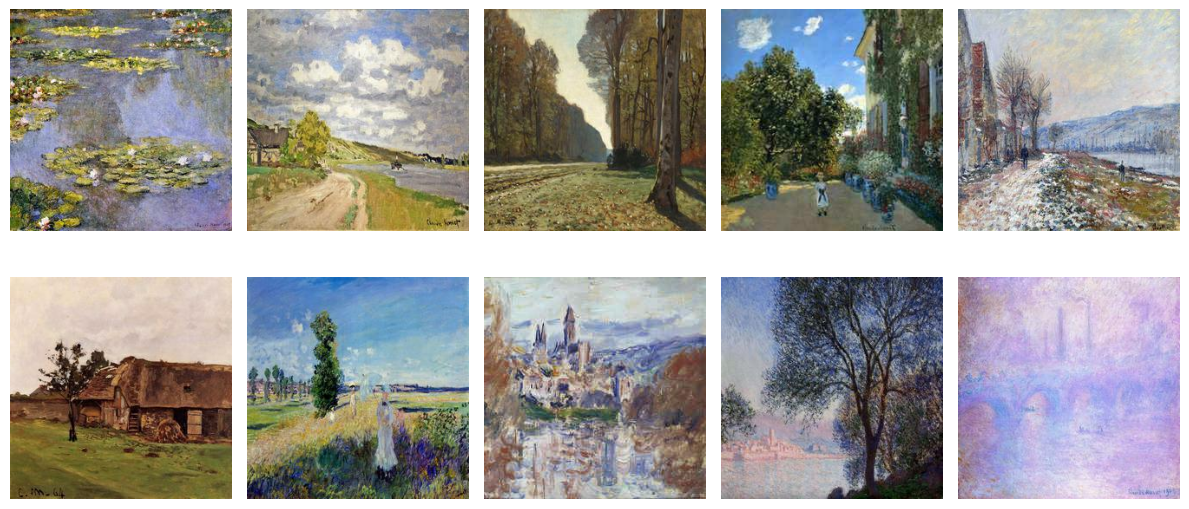

In [3]:
import glob

monet_paths = glob.glob("../input/gan-getting-started/monet_jpg/*.jpg")

print(f'Total number of Monet images: {len(monet_paths)}')

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for ax, img_path in zip(axes.flatten(), monet_paths[:10]):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

Total number of Photo images: 7038


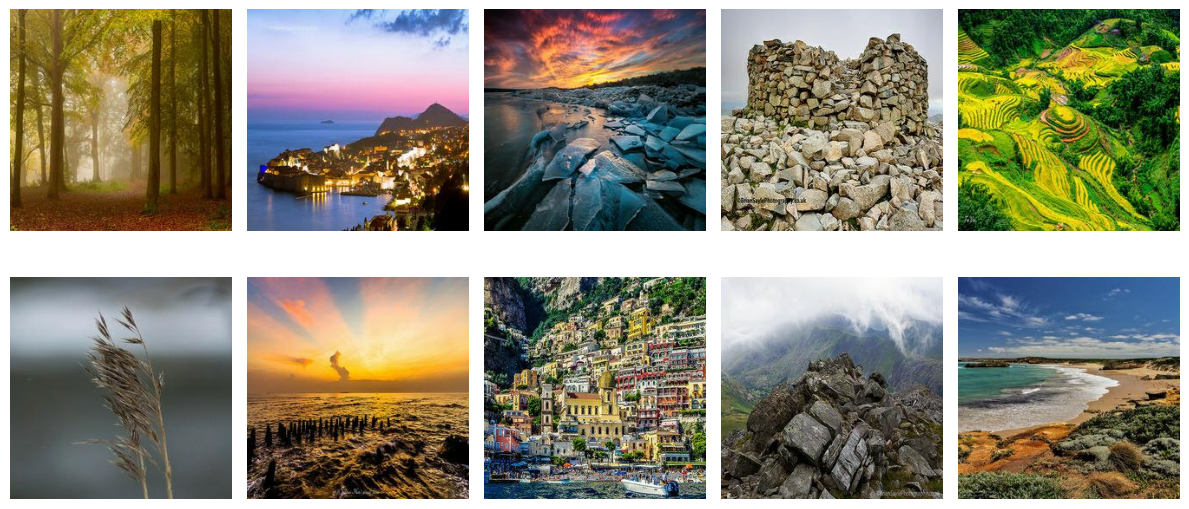

In [4]:
photo_paths = glob.glob("../input/gan-getting-started/photo_jpg/*.jpg")

print(f'Total number of Photo images: {len(photo_paths)}')

fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for ax, img_path in zip(axes.flatten(), photo_paths[:10]):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

**Print the dimensions of the image and the dominant colors in the image**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


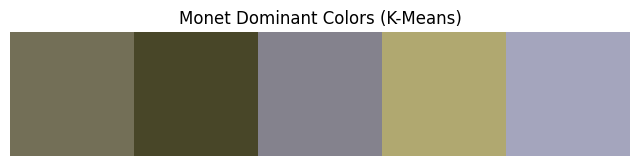

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


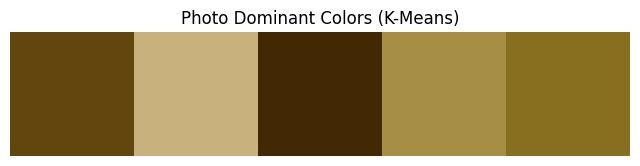

In [5]:
import cv2
from sklearn.cluster import KMeans

img = cv2.imread(monet_paths[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.reshape((-1, 3))

kmeans = KMeans(n_clusters=5)
kmeans.fit(img)
colors = kmeans.cluster_centers_

plt.figure(figsize=(8, 2))
plt.imshow([colors.astype(int)])
plt.axis("off")
plt.title("Monet Dominant Colors (K-Means)")
plt.show()


photo_img = cv2.imread(photo_paths[0])
photo_img = cv2.cvtColor(photo_img, cv2.COLOR_BGR2RGB)
photo_img = photo_img.reshape((-1, 3))

photo_kmeans = KMeans(n_clusters=5)
photo_kmeans.fit(photo_img)
colors = photo_kmeans.cluster_centers_

plt.figure(figsize=(8, 2))
plt.imshow([colors.astype(int)])
plt.axis("off")
plt.title("Photo Dominant Colors (K-Means)")
plt.show()

In [6]:
'''
import cv2

img = cv2.imread(monet_paths[0])  
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
color = ('r', 'g', 'b')
for i, col in enumerate(color):
    hist = cv2.calcHist([img], [i], None, [256], [0, 256])
    plt.plot(hist, color=col)

plt.title("Color Distribution (RGB Histogram)")
plt.xlabel("Color Value")
plt.ylabel("Pixel Count")
plt.show()
'''

'\nimport cv2\n\nimg = cv2.imread(monet_paths[0])  \nimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n\nplt.figure(figsize=(10, 5))\ncolor = (\'r\', \'g\', \'b\')\nfor i, col in enumerate(color):\n    hist = cv2.calcHist([img], [i], None, [256], [0, 256])\n    plt.plot(hist, color=col)\n\nplt.title("Color Distribution (RGB Histogram)")\nplt.xlabel("Color Value")\nplt.ylabel("Pixel Count")\nplt.show()\n'

# Model definition

**CustomDataset**

In [7]:
# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith('.jpg')]
        if num_samples is not None:
            self.image_files = random.sample(self.image_files, num_samples)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

**Define the generator and discriminator**

In [8]:
# 定义生成器和判别器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 使用 nn.Sequential 定义模型
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # 输出范围[-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# 判别器
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 使用 nn.Sequential 定义模型
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=1),  # 输出一个标量
            nn.Sigmoid()  # 输出范围[0, 1]
        )

    def forward(self, x):
        return self.model(x)

**Define the CycleGAN model**

In [9]:
# 定义CycleGAN模型
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        self.G_A2B = Generator()  # 从A（照片）到B（莫奈风格）的生成器
        self.G_B2A = Generator()  # 从B到A的生成器
        self.D_A = Discriminator()  # 判别A的判别器
        self.D_B = Discriminator()  # 判别B的判别器

    def forward(self, x):
        pass

# Data loading and preprocessing

In [10]:
# 数据加载与预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 加载数据集（只取100张图像）
photo_dataset = CustomDataset(root_dir='/kaggle/input/gan-getting-started/photo_jpg', transform=transform, num_samples=20)
monet_dataset = CustomDataset(root_dir='/kaggle/input/gan-getting-started/monet_jpg', transform=transform, num_samples=20)
# 加载数据集
#photo_dataset = CustomDataset(root_dir='/kaggle/input/gan-getting-started/photo_jpg', transform=transform)
#monet_dataset = CustomDataset(root_dir='/kaggle/input/gan-getting-started/monet_jpg', transform=transform)

# 创建 DataLoader
photo_loader = DataLoader(photo_dataset, batch_size=32, shuffle=True)
monet_loader = DataLoader(monet_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CycleGAN().to(device)

**Define the loss function and optimizer**

In [11]:
# 定义损失函数
criterion_adv = nn.MSELoss()  # 对抗损失
criterion_cycle = nn.L1Loss()  # 循环一致性损失
criterion_identity = nn.L1Loss()  # 身份损失

# 定义优化器
optimizer_G = optim.Adam(list(model.G_A2B.parameters()) + list(model.G_B2A.parameters()), lr=0.0002)
optimizer_D = optim.Adam(list(model.D_A.parameters()) + list(model.D_B.parameters()), lr=0.0002)

**Tool methods for file saving and comparison**

In [12]:

# 定义保存单张图像的函数
def save_images(images, path):
    """
    保存单张图像
    :param images: 图像（Tensor，形状为 [1, C, H, W]）
    :param path: 保存路径
    """
    images = (images + 1) / 2  # 反归一化到 [0, 1]
    images = images.clamp(0, 1)  # 确保像素值在 [0, 1] 范围内
    grid = vutils.make_grid(images, nrow=1)  # 将图像拼接成网格
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # 转换为 (H, W, C) 并显示
    plt.axis('off')
    plt.savefig(path)
    plt.close()

# 定义显示对比图片的函数
def show_comparison(real, fake, title="Comparison"):
    """
    并排显示原图和生成图
    :param real: 原图（Tensor，形状为 [C, H, W]）
    :param fake: 生成图（Tensor，形状为 [C, H, W]）
    :param title: 图像标题
    """
    real = (real + 1) / 2  # 反归一化到 [0, 1]
    fake = (fake + 1) / 2  # 反归一化到 [0, 1]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(real.permute(1, 2, 0).cpu().numpy())  # 转换为 (H, W, C) 并显示
    plt.title("Real Photo")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fake.permute(1, 2, 0).cpu().numpy())  # 转换为 (H, W, C) 并显示
    plt.title("Fake Monet")
    plt.axis('off')

    plt.suptitle(title)
    plt.show()


# 定义绘制损失曲线的函数
def plot_losses(G_losses, D_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(G_losses, label="Generator Loss")
    plt.plot(D_losses, label="Discriminator Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Generator and Discriminator Loss During Training")
    plt.legend()
    plt.show()


# Model training

In [13]:
import torchvision.utils as vutils
# 训练循环
def train_cyclegan(model, dataloader_A, dataloader_B, num_epochs=100):
    G_losses = []
    D_losses = []

    # 创建保存图片的目录
    #os.makedirs("real_photos", exist_ok=True)
    #os.makedirs("fake_monet", exist_ok=True)

    for epoch in range(num_epochs):
        for (real_A, real_B) in zip(dataloader_A, dataloader_B):
            real_A = real_A.to(device)  # 将数据移动到GPU（如果有）
            real_B = real_B.to(device)

            # 训练生成器
            optimizer_G.zero_grad()

            # 生成莫奈风格的图像
            fake_B = model.G_A2B(real_A)
            # 生成照片风格的图像
            fake_A = model.G_B2A(real_B)

            # 对抗损失
            pred_fake_B = model.D_B(fake_B)
            loss_G_A2B = criterion_adv(pred_fake_B, torch.ones_like(pred_fake_B))  # 让判别器认为生成的图像是真实的

            pred_fake_A = model.D_A(fake_A)
            loss_G_B2A = criterion_adv(pred_fake_A, torch.ones_like(pred_fake_A))  # 让判别器认为生成的图像是真实的

            # 循环一致性损失
            cycle_A = model.G_B2A(fake_B)
            loss_cycle_A = criterion_cycle(cycle_A, real_A)

            cycle_B = model.G_A2B(fake_A)
            loss_cycle_B = criterion_cycle(cycle_B, real_B)

            # 身份损失
            identity_A = model.G_B2A(real_A)
            loss_identity_A = criterion_identity(identity_A, real_A)

            identity_B = model.G_A2B(real_B)
            loss_identity_B = criterion_identity(identity_B, real_B)

            # 总生成器损失
            loss_G = loss_G_A2B + loss_G_B2A + 10.0 * (loss_cycle_A + loss_cycle_B) + 5.0 * (loss_identity_A + loss_identity_B)
            loss_G.backward()
            optimizer_G.step()

            # 训练判别器
            optimizer_D.zero_grad()

            # 判别器对真实图像的损失
            pred_real_A = model.D_A(real_A)
            loss_D_real_A = criterion_adv(pred_real_A, torch.ones_like(pred_real_A))

            pred_real_B = model.D_B(real_B)
            loss_D_real_B = criterion_adv(pred_real_B, torch.ones_like(pred_real_B))

            # 判别器对生成图像的损失
            pred_fake_A = model.D_A(fake_A.detach())
            loss_D_fake_A = criterion_adv(pred_fake_A, torch.zeros_like(pred_fake_A))

            pred_fake_B = model.D_B(fake_B.detach())
            loss_D_fake_B = criterion_adv(pred_fake_B, torch.zeros_like(pred_fake_B))

            # 总判别器损失
            loss_D = (loss_D_real_A + loss_D_fake_A + loss_D_real_B + loss_D_fake_B) / 4
            loss_D.backward()
            optimizer_D.step()

            # 记录损失
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

        # 打印损失
        print(f"Epoch [{epoch+1}/{num_epochs}], G Loss: {loss_G.item():.4f}, D Loss: {loss_D.item():.4f}")
        if epoch % 10 == 0:
            with torch.no_grad():
                fake_B = model.G_A2B(real_A)  # 生成莫奈风格的图像
                show_comparison(real_A[0], fake_B[0], title=f"Epoch {epoch+1} Comparison")

        '''
        # 保存原始照片和生成的图片
        if epoch % 10 == 0:
            with torch.no_grad():
                fake_B = model.G_A2B(real_A)
                for i, (real, fake) in enumerate(zip(real_A, fake_B)):
                    # 保存原始照片
                    real_path = os.path.join("real_photos", f"epoch_{epoch+1}_image_{i}.png")
                    save_images(real.unsqueeze(0), path=real_path)

                    # 保存生成的莫奈风格图片
                    fake_path = os.path.join("fake_monet", f"epoch_{epoch+1}_image_{i}.png")
                    save_images(fake.unsqueeze(0), path=fake_path)
        '''
    # 绘制损失曲线
    plot_losses(G_losses, D_losses)    

In [14]:
# 定义加载并显示对比图片的函数
def load_and_show_comparison(real_dir, fake_dir, num_images=5):
    """
    加载并显示原始照片和生成的图片的对比
    :param real_dir: 原始照片目录
    :param fake_dir: 生成的图片目录
    :param num_images: 显示的图片数量
    """
    real_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.png')]
    fake_files = [os.path.join(fake_dir, f) for f in os.listdir(fake_dir) if f.endswith('.png')]
    real_files = sorted(real_files)  # 按文件名排序
    fake_files = sorted(fake_files)  # 按文件名排序

    plt.figure(figsize=(15, 6))
    for i, (real_path, fake_path) in enumerate(zip(real_files[:num_images], fake_files[:num_images])):
        # 加载原始照片
        real_image = Image.open(real_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(real_image)
        plt.title("Real Photo")
        plt.axis('off')

        # 加载生成的图片
        fake_image = Image.open(fake_path)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(fake_image)
        plt.title("Fake Monet")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



**Start training**

In [15]:
#train_cyclegan(model, photo_loader, monet_loader, num_epochs=10)
    
# 训练结束后加载并显示对比图片
#load_and_show_comparison("real_photos", "fake_monet")

Epoch [1/40], G Loss: 14.0947, D Loss: 0.2521


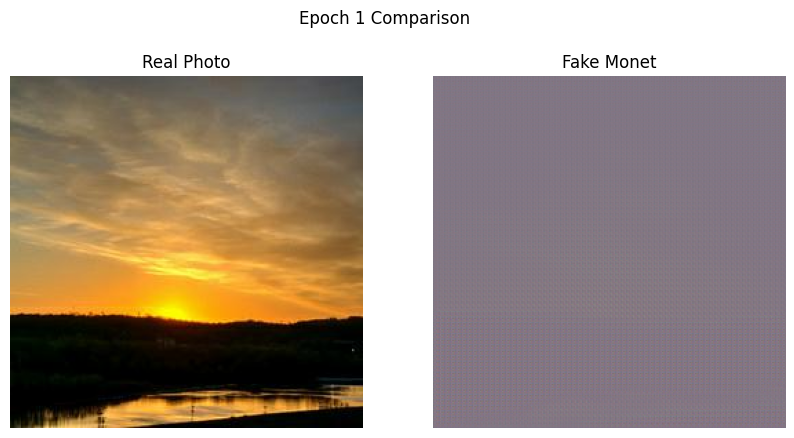

Epoch [2/40], G Loss: 14.0159, D Loss: 0.2428
Epoch [3/40], G Loss: 13.9414, D Loss: 0.2343
Epoch [4/40], G Loss: 13.8647, D Loss: 0.2265
Epoch [5/40], G Loss: 13.7780, D Loss: 0.2192
Epoch [6/40], G Loss: 13.6746, D Loss: 0.2124
Epoch [7/40], G Loss: 13.5456, D Loss: 0.2063
Epoch [8/40], G Loss: 13.3835, D Loss: 0.2009
Epoch [9/40], G Loss: 13.1783, D Loss: 0.1965
Epoch [10/40], G Loss: 12.9225, D Loss: 0.1934
Epoch [11/40], G Loss: 12.6070, D Loss: 0.1917


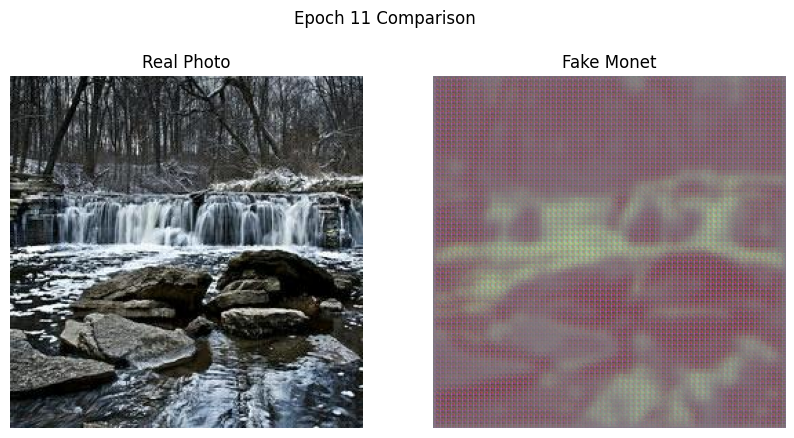

Epoch [12/40], G Loss: 12.2235, D Loss: 0.1916
Epoch [13/40], G Loss: 11.7660, D Loss: 0.1929
Epoch [14/40], G Loss: 11.2343, D Loss: 0.1955
Epoch [15/40], G Loss: 10.6454, D Loss: 0.1992
Epoch [16/40], G Loss: 10.0433, D Loss: 0.2036
Epoch [17/40], G Loss: 9.4987, D Loss: 0.2083
Epoch [18/40], G Loss: 9.0746, D Loss: 0.2127
Epoch [19/40], G Loss: 8.7958, D Loss: 0.2161
Epoch [20/40], G Loss: 8.6409, D Loss: 0.2183
Epoch [21/40], G Loss: 8.5333, D Loss: 0.2193


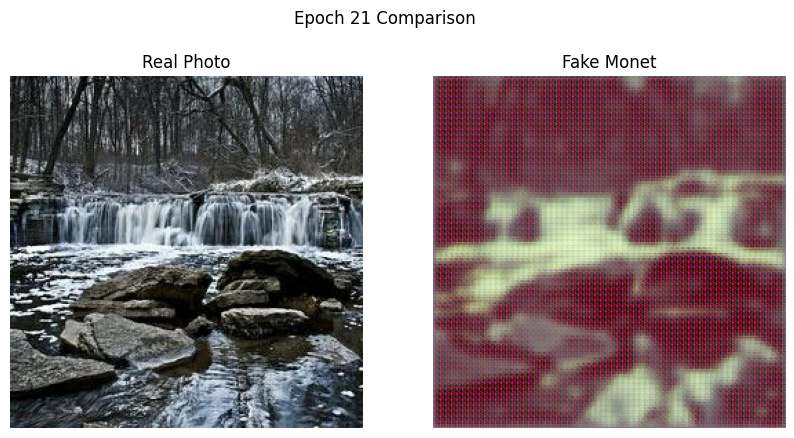

Epoch [22/40], G Loss: 8.3872, D Loss: 0.2200
Epoch [23/40], G Loss: 8.1560, D Loss: 0.2212
Epoch [24/40], G Loss: 7.8395, D Loss: 0.2234
Epoch [25/40], G Loss: 7.4761, D Loss: 0.2276
Epoch [26/40], G Loss: 7.1509, D Loss: 0.2352
Epoch [27/40], G Loss: 6.9668, D Loss: 0.2469
Epoch [28/40], G Loss: 6.9109, D Loss: 0.2597
Epoch [29/40], G Loss: 6.8421, D Loss: 0.2683
Epoch [30/40], G Loss: 6.7474, D Loss: 0.2715
Epoch [31/40], G Loss: 6.6628, D Loss: 0.2710


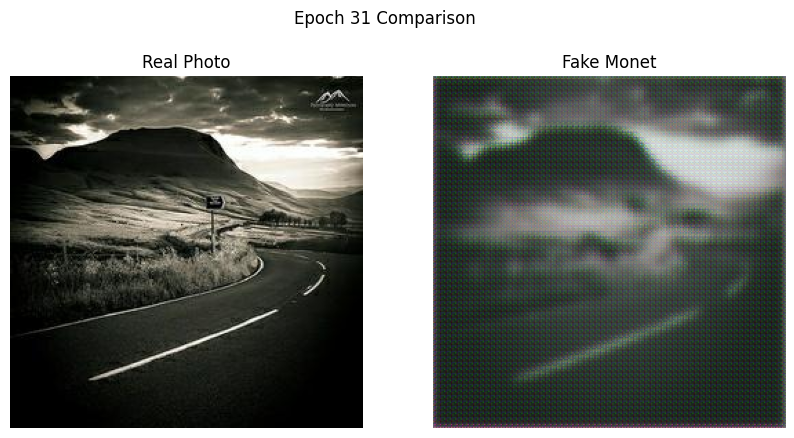

Epoch [32/40], G Loss: 6.5741, D Loss: 0.2698
Epoch [33/40], G Loss: 6.4638, D Loss: 0.2694
Epoch [34/40], G Loss: 6.3767, D Loss: 0.2699
Epoch [35/40], G Loss: 6.3454, D Loss: 0.2700
Epoch [36/40], G Loss: 6.3111, D Loss: 0.2688
Epoch [37/40], G Loss: 6.2253, D Loss: 0.2665
Epoch [38/40], G Loss: 6.1159, D Loss: 0.2638
Epoch [39/40], G Loss: 6.0079, D Loss: 0.2613
Epoch [40/40], G Loss: 5.9069, D Loss: 0.2592


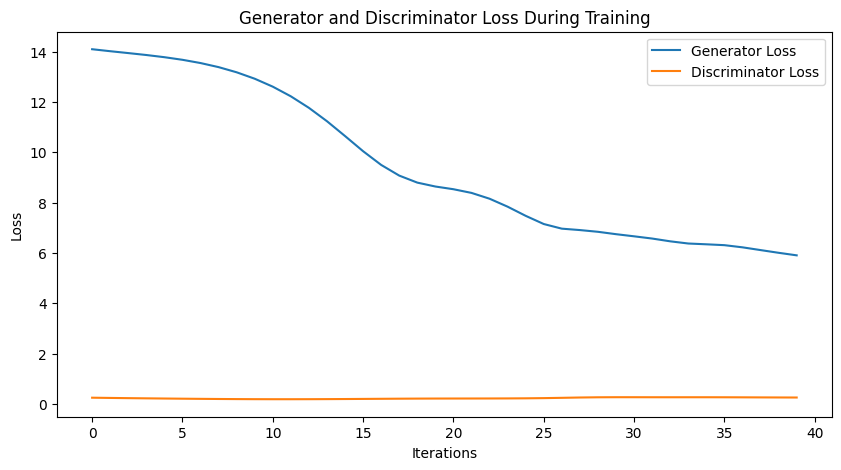

FileNotFoundError: [Errno 2] No such file or directory: 'real_photos'

In [16]:
train_cyclegan(model, photo_loader, monet_loader, num_epochs=40)
# 训练结束后加载并显示对比图片
#load_and_show_comparison("real_photos", "fake_monet")


# 7000 images were generated

In [ ]:
import shutil

# 定义生成图像并保存到临时目录的函数
def generate_and_save_images_to_tmp(model, dataloader, num_images=7000, output_dir="/tmp/generated_images"):
    """
    生成图像并保存到临时目录
    :param model: 训练好的模型
    :param dataloader: 数据加载器
    :param num_images: 生成的图像数量
    :param output_dir: 临时目录路径
    """
    os.makedirs(output_dir, exist_ok=True)  # 创建临时目录
    model.eval()  # 将模型设置为评估模式
    generated_count = 0

    with torch.no_grad():
        while generated_count < num_images:  # 持续生成直到达到目标数量
            for real_A in dataloader:
                real_A = real_A.to(device)
                fake_B = model.G_A2B(real_A)  # 生成莫奈风格的图像

                for i, image in enumerate(fake_B):
                    if generated_count >= num_images:
                        break

                    # 保存生成的图像
                    save_path = os.path.join(output_dir, f"image_{generated_count}.png")
                    save_images(image.unsqueeze(0), path=save_path)
                    generated_count += 1

                if generated_count >= num_images:
                    break

    print(f"Generated {generated_count} images and saved to {output_dir}")

# 定义压缩目录为 ZIP 文件的函数
def zip_directory(directory, zip_name):
    """
    将指定目录压缩为 ZIP 文件
    :param directory: 要压缩的目录
    :param zip_name: 生成的 ZIP 文件名
    """
    shutil.make_archive(zip_name, 'zip', directory)
    print(f"Directory '{directory}' has been zipped to '{zip_name}.zip'")

In [ ]:
'''
# 生成 7000 张图像并保存到临时目录
generate_and_save_images_to_tmp(model, photo_loader, num_images=7000, output_dir="/tmp/generated_images")
    
# 压缩临时目录为 ZIP 文件
zip_directory("/tmp/generated_images", "images")



import os
 
# 指定目录路径
directory_path = '/tmp/generated_images'
 
# 获取目录下的所有文件和文件夹名称
entries = os.listdir(directory_path)
 
# 过滤出文件数量（不包括子目录）
file_count = len([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])
 
print(f"Number of files in {directory_path}: {file_count}")
'''